Qui ho riportato un po' commentato:
- come aprire un ds e da con xarray
- clip su Italia
- le conversioni
- un plot sul mondo
- un tetnativo di O3 nel tempo ma ancora 1 asse è da aggiustare
- una prova con cartopy

In [ ]:
conda install -c conda-forge cartopy

In [90]:
import numpy as np
import geopandas
import rioxarray
import xarray as xr
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import numpy.ma as ma
import datetime
from matplotlib import image as im
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy.crs as ccrs

In [7]:
#dataset [ds] opening with all variables ['tcco', 'gtco3', 'tcno2'] considered for all time series
ds = xr.open_dataset("./italiaecmwf.nc", decode_coords="all")[['tcco', 'gtco3', 'tcno2']]
#datarray [da] extracted from dataset chosing a single variable ['tcco']
da=ds['tcco']

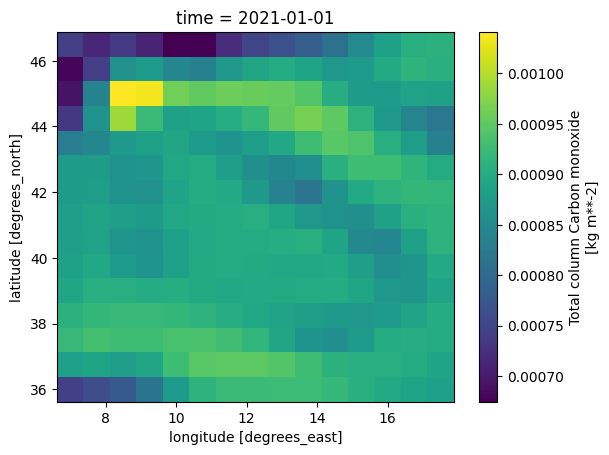

In [10]:
#plot of timestep=0 of the datarray [2021-01-01]
da[0].plot()

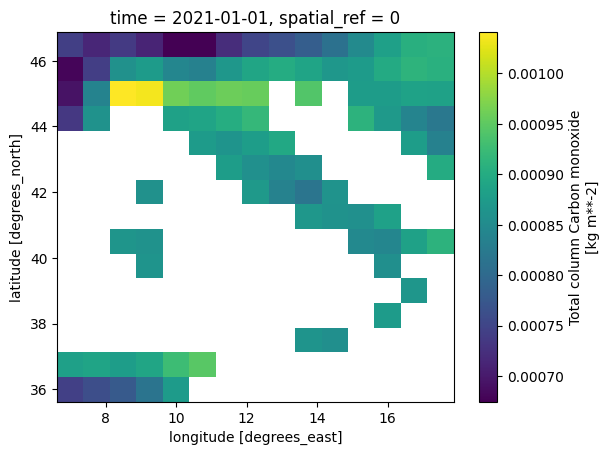

In [14]:
#SIMILARLY BUT WITH CLIPPING

#import dataset
ds = xr.open_dataset("./italiaecmwf.nc", decode_coords="all")[['tcco', 'gtco3', 'tcno2']]
#define reference system of ds
ds.rio.write_crs("epsg:4326", inplace=True)
#import shapefile and define reference system of shp
shapefile = geopandas.read_file('./italy_shapefile/italy_shapefile.shp', crs="epsg:4326")
#clipping
ds_clip = ds.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs, drop=True)

#simple plot
ds_clip.tcco[0].plot()

(array([ 25., 159., 273., 434., 866., 792., 338.,  75.,  11.,   3.]),
 array([0.00060058, 0.00065938, 0.00071817, 0.00077696, 0.00083576,
        0.00089455, 0.00095335, 0.00101214, 0.00107093, 0.00112973,
        0.00118852]),
 <BarContainer object of 10 artists>)

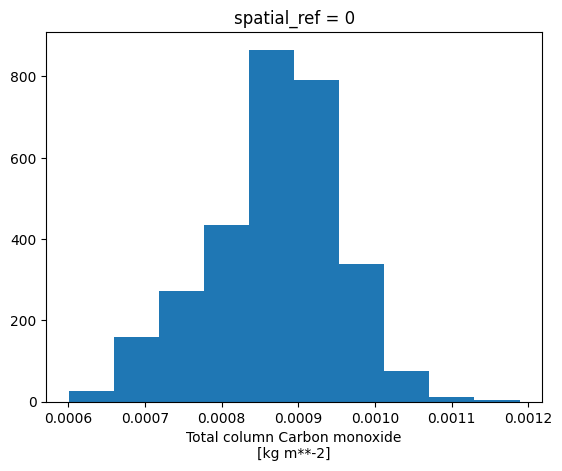

In [17]:
#ok se non gli assegni il time step ti fa l'istogramma
ds_clip.tcco.plot()

In [53]:
#conversioni

#convert to  [co] ppbv
da_tcco_clip=ds_clip['tcco']
da_tcco_clip=da_tcco_clip*28.97 / 28.011 * 1000000000

da_tcco=ds['tcco']
da_tcco=da_tcco*28.97 / 28.011 * 1000000000

# conversioni

[ozone]
factor=28.97 / 47.998 * 1e9
unit=ppbv

[methane]
factor = 28.97 / 16.044 * 1e9
unit=ppbv

[carbon_dioxide]
factor = 28.97 / 44.01 * 1e6
unit=ppmv

[carbon_monoxide]
factor= 28.97 / 28.011 * 1e9
unit=ppbv

[nitrogen_dioxide]
factor= 28.97 / 46.0055 * 1e9
unit=ppbv

[nitrogen_oxides]
factor=28.97 / 46.1 * 1e9
unit=ppbv

[nitrogen_monoxide]
factor=28.97 / 30.01 * 1e9
unit=ppbv

[formaldehyde]
factor=28.97 / 30.03 * 1e9
unit=ppbv

[sulphur_dioxide]
factor=28.97 / 64.066 * 1e9
unit=ppbv

[total_column_carbon_monoxide]
factor=6.0221415e23*1e-18/(1e4*28.01e-3)
unit=10^18 molecules / cm2

[total_column_ozone]
factor=46698
unit=DU

[total_column_formaldehyde]
factor=2004008
unit=10^15 molecules / cm2

[total_column_nitrogen_dioxide]
factor=6.0221415e23*1e-15/(1e4*46.01e-3)
unit=10^15 molecules / cm2

[total_column_sulphur_dioxide]
factor=939931.55923209002
unit=10^15 molecules / cm2

In [4]:
#function to move from 0+360 to -180+180 long
def ds_swaplon(ds):
    return ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')

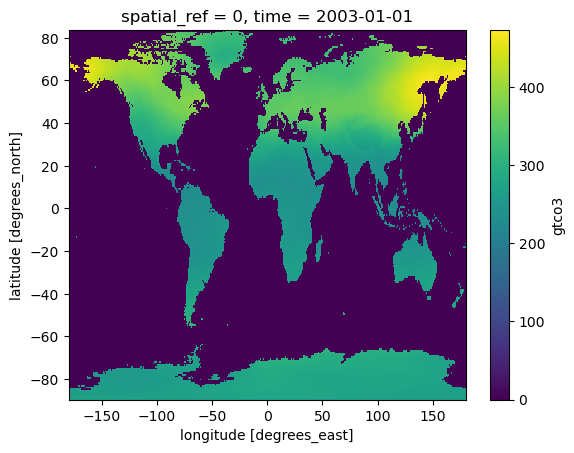

In [12]:
#import all world dataset (ds) with oyone O3 v variable
ds = xr.open_dataset("./nc_files/prova2.nc", decode_coords="all")[['gtco3']]
#apply function to lingitudinally shift
ds = ds_swaplon(ds)
#ectract datarray (da)
daO3=ds.gtco3
#import world shp and cli da
shapefile = geopandas.read_file('./mondo_shp/mondo.shp', crs="epsg:4326")
daO3.rio.write_crs("epsg:4326", inplace=True)
clipped = daO3.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs, drop=True)

#montly mean and conversion to DU unit befor a simple clip
monthly_O3 = (clipped.resample(time="1MS", restore_coord_dims=True).sum(dim='time'))/30 #monthly mean
monthly_O3 =monthly_O3 *46698 #conversion DU
monthly_O3[0].plot()

In [ ]:
#TRYING WITH CARTOPY

In [36]:
from matplotlib.colors import ListedColormap

# Array containing 15 colours ranging from white, grey, yellow and orange to red.
# Each row in the array contains three numbers for red, green and blue respectively.
# The numbers represent intensity, from 0 (black) to 256 (white).
matrix = np.array([[256, 256, 256],
                   [210, 214, 234],
                   [167, 174, 214],
                   [135, 145, 190],
                   [162, 167, 144],
                   [189, 188, 101],
                   [215, 209, 57],
                   [242, 230, 11],
                   [243, 197, 10],
                   [245, 164, 8],
                   [247, 131, 6],
                   [248, 98, 5],
                   [250, 65, 3],
                   [252, 32, 1],
                   [254, 0, 0]])
n = 17 # Multiplication number

cams = np.ones((253, 4)) # Initial empty colormap, to be filled by the colours in 'matrix'.

# This loop fills in the empty 'cams' colormap with each of the 15 colours in 'matrix'
# multiplied by 'n'. Each colour is divided by 256 to normalise from 0 (black) to 1 (white). 
for i in range(matrix.shape[0]):
    cams[(i*n):((i+1)*n),:] = np.array([matrix[i,0]/256, matrix[i,1]/256, matrix[i,2]/256, 1])

# The final colormap is given by 'camscmp', which uses the Matplotlib class 'ListedColormap(Colormap)'
# to generate a colormap object from the list of colours provided by 'cams'.
camscmp = ListedColormap(cams)

In [60]:
np.max(np.array(da_tcco[0]))

1076511.1073851585

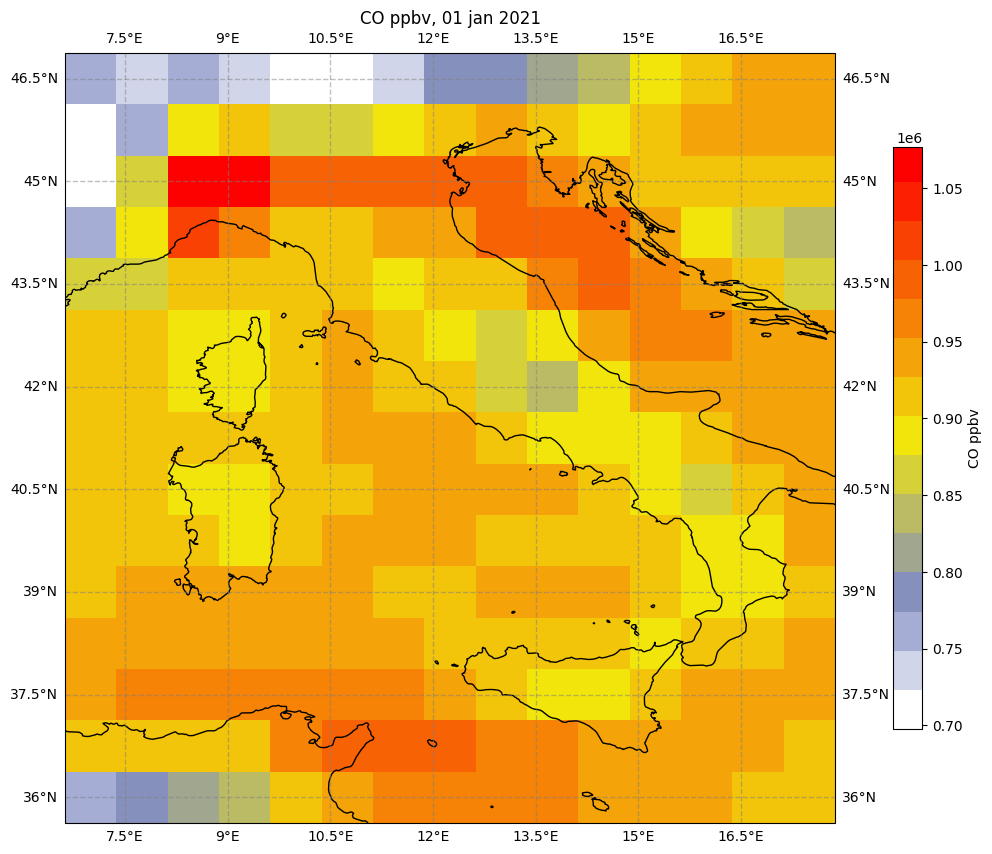

In [62]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
ax.set_title('CO ppbv, 01 jan 2021', fontsize=12) 
im = plt.pcolormesh(da_tcco.longitude, da_tcco.latitude, da_tcco[0,:,:], cmap=camscmp, vmin=697853.0436754227, vmax=1076511.1073851585) 
ax.coastlines(color='black') 
cbar = plt.colorbar(im, fraction=0.025, pad=0.05)
cbar.set_label('CO ppbv') 
#fig.savefig(f'{DATADIR}/CAMS_global_forecast_AOD_2021-08-01_CAMS-cmap.png')

# TRYING WITH ANOTHER NC (FULL AREA)

In [1]:
#function for moving to -180° to +180° at 0° to 360° longitude

def ds_swaplon(ds):
    return ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby('longitude')

In [40]:
ds = xr.open_dataset("./nc_files/prova3.nc", decode_coords="all")[['gtco3']]
#apply function to lingitudinally shift
ds = ds_swaplon(ds)
#ectract datarray (da)
daO3=ds.gtco3
daO3 = ((daO3.resample(time="1W", restore_coord_dims=True).sum(dim='time')))/7
daO3=np.array(daO3)


<xarray.DataArray 'time' (time: 418)>
array(['2003-01-05T00:00:00.000000000', '2003-01-12T00:00:00.000000000',
       '2003-01-19T00:00:00.000000000', ..., '2010-12-19T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2011-01-02T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2003-01-05 2003-01-12 ... 2011-01-02

In [23]:
#inizializzo il numero di righe del raster di output
i=0
#inizializzo il numero di colonne del raster di output
d=0 
#il numero di colonne è la terza dimesione del datarray daO3
col=daO3.shape[2] 
#il numero di righe è la seconda dimesione del datarray daO3
row=daO3.shape[1] 
#il numero di raster (giorni) è la prima dimesione del datarray daO3 (in questo caso è il timestep del datset esatto)
numtime=daO3.shape[0]
#definisco la dimensione del raster di output
dim=(row, numtime) 
#inizializzo il raster di output
output=np.empty(dim)*0

for d in range (0,numtime,1): #per ogni step temporale fino all'ultimi considerato
    for i in range (row): #per latitudine (riga)
        j=0 #inializzo le colonne
        for j in range (col): #per ogni colonna (del raster di input)
            output[i,d]=output[i,d]+daO3[d,i,j] # il file output avrà nella riga i e colonna d (pari al tempo) la somma di tutti i valori per qella latitudine
            j=j+1
        output[i,d]=output[i,d]/col  # il file output è mediato per il numero di colonne di input
        i=i+1
    d=d+1

In [43]:
#conversione in DU
output=output*46698

In [45]:
np.min(np.array(output))

108.93609728291631

C:\Users\User\AppData\Local\Temp\ipykernel_14172\3548761311.py:4: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ybound(lower="90",upper="90")


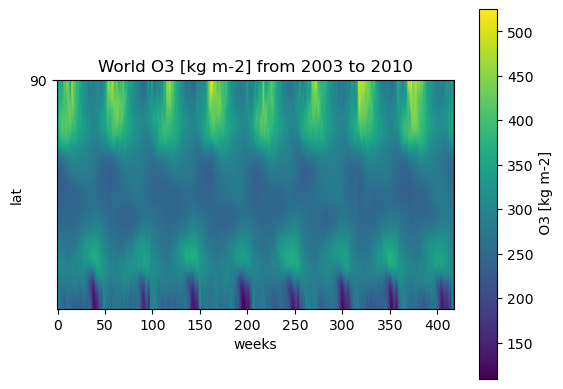

In [89]:

fig, ax = plt.subplots()
ax.imshow(output)
ax.set_xlabel("weeks")
ax.set_ybound(lower="90",upper="90")

ax.set_ylabel("lat")
ax.set_title('World O3 [kg m-2] from 2003 to 2010')
plt.imshow(output)
plt.colorbar(label=' O3 [kg m-2]')
    

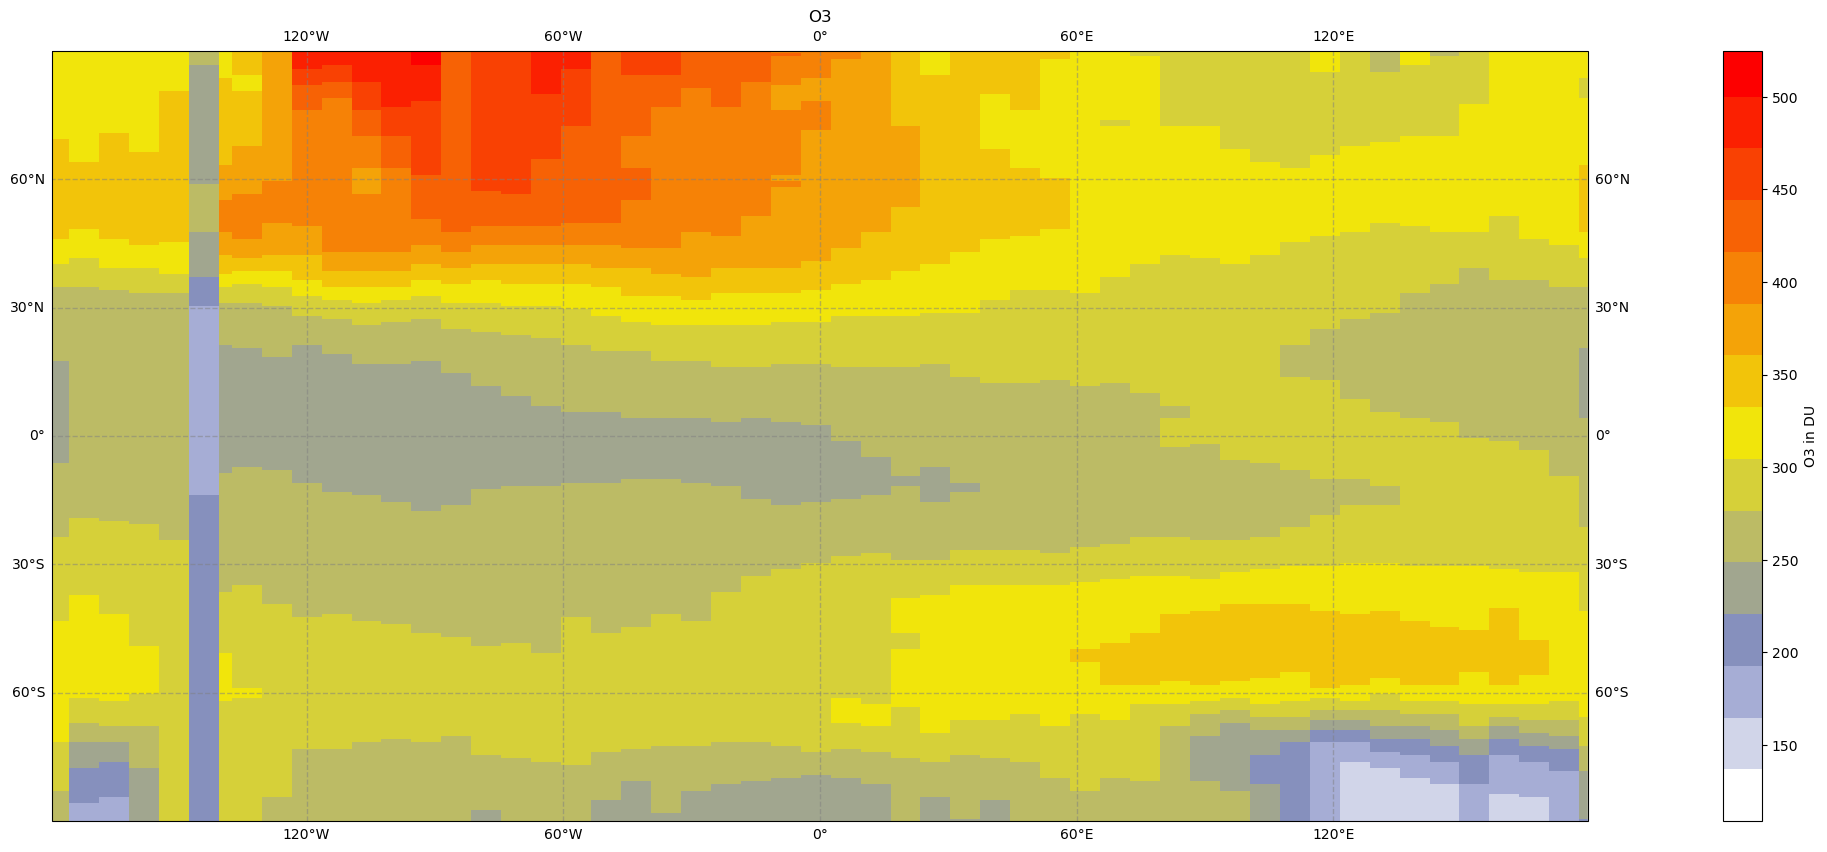

In [49]:
ds = xr.open_dataset("./nc_files/prova3.nc", decode_coords="all")[['gtco3']]
#apply function to lingitudinally shift
ds = ds_swaplon(ds)
#ectract datarray (da)
daO3=ds.gtco3
daO3 = ((daO3.resample(time="1W", restore_coord_dims=True).sum(dim='time')))/7
fig = plt.figure(figsize=(35, 10))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
ax.set_title('O3', fontsize=12) 
im = plt.pcolormesh(daO3.time, daO3.latitude, output, cmap=camscmp, vmin=np.min(np.array(output)), vmax=np.max(np.array(output))) 
#ax.coastlines(color='black') 
cbar = plt.colorbar(im, fraction=0.025, pad=0.05)
cbar.set_label('O3 in DU') 